In [17]:
import pandas as pd
import glob
from sklearn.neighbors import BallTree
import networkx as nx
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import ConvexHull
import pathlib
import os

In [147]:
DIRECTORY = r''
paths = glob.glob(DIRECTORY + '/*.csv')
RADIUS = 10

In [148]:
dfs = []
for path in paths: 
    filename = pathlib.PurePath(path).name
    print(filename)
    
    data = pd.read_csv(file, delimiter=';')
    data = data[['Serie', 'X', 'Y', 'Center X', 'Center Y']]
    data = data.dropna()
    
    serie_list = np.unique(data['Serie'])
    dfs_serie = []
    
    for serie in serie_list:
    
        data_serie = data[data['Serie'] == serie] 
        data_serie = data_serie.reset_index()
        
        # Compute local density
        
        n_rows = len(data_serie)

        x =  np.asarray(data_serie['X'])
        y =  np.asarray(data_serie['Y'])

        points = np.asarray([x,y]).transpose()
        G = nx.Graph()
        pos = {i: (x[i], y[i]) for i in range(n_rows)}
        G.add_nodes_from(pos.keys())
        tree = BallTree(points, leaf_size=10)    
        query = tree.query_radius(points, r=RADIUS, count_only=False)   #index correspond to id_roi+1

        for i in range(len(query)): 
            for j in query[i]:
                G.add_edge(i, j)  

        nneighbors = []
        for k in range(n_rows):
            neighbors = query[k]
            nneighbors.append(len(query[k])-1)

        data_serie['local_density'] = np.array(nneighbors) / (np.pi*radius**2)

        # Compute avg distance for 6 nearest neighbors

        pts=np.array([[x[i],y[i]] for i in range(len(x))])
        nbrs = NearestNeighbors(n_neighbors=7, algorithm='ball_tree').fit(pts)
        distances, indices = nbrs.kneighbors(pts)

        mean_distances = []
        for distance in distances:
            mean_distances.append(np.mean(distance[1::]))

        data_serie['avg_dist_6n'] = mean_distances

        # Compute distance to placode center
        
        x_center = data_serie['Center X'][0]
        y_center = data_serie['Center Y'][1]
        dist_center = []
        for xi, yi in zip(x,y):
            dist_center.append(np.sqrt( (xi-x_center)**2 + (yi-y_center)**2 )) 

        data_serie['dist_to_center'] = dist_center

        # Compute convex hull area
        
        hull = ConvexHull(points)
        data_serie['hull_area'] = [hull.area]*len(data_serie)
        data_serie['hull_density'] = [len(data_serie) / hull.area ] * len(data_serie)

        # Add embryo name to dataframe
        
        data_serie['embryo'] = [filename.replace('.csv','')]* len(data_serie)
        dfs_serie.append(data_serie)
    
    data_serie_full = pd.concat(dfs_serie)
    dfs.append(data_serie_full)
    
# Export data
df = pd.concat(dfs)
out_directory = r''
foldername = pathlib.PurePath(folder).name
df.to_excel(os.path.join(out_directory, foldername + '.xlsx')) 

embryo1.csv
embryo2.csv
embryo7.csv
embryoB.csv
embryoH.csv


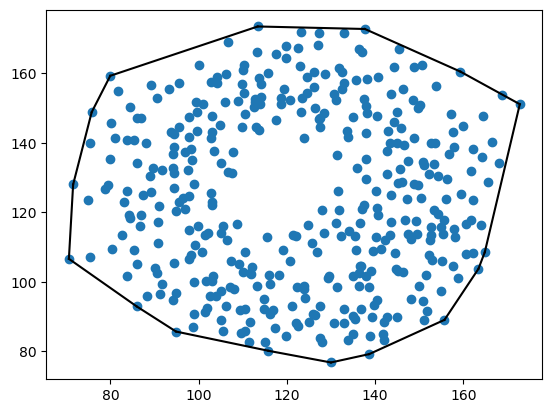

In [52]:
# Compute ConvexHull

import matplotlib.pyplot as plt
plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
    